1. Importations et Configuration

Commençons par importer les bibliothèques nécessaires et configurer le périphérique (GPU/CPU).

In [104]:
import os
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import json
from pathlib import Path
import matplotlib.pyplot as plt


# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Appareil utilisé : {device}")

# Configuration des chemins (Adapté pour Jupyter : on utilise le dossier courant)
base_dir = os.getcwd() 
os.makedirs("saved_losses", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)
s_losses_dir = os.path.join(base_dir, "saved_losses")
s_models_dir = os.path.join(base_dir, "saved_models")
mtg_dir = os.path.join(base_dir, "mtg_dataset")

# Vérification rapide
if not os.path.exists(mtg_dir):
    print(f"⚠️ Attention : Le dossier {Path(mtg_dir).stem} est introuvable.")
else:
    print(f"Dossier des données trouvé : {Path(mtg_dir).stem}")

Appareil utilisé : cuda
Dossier des données trouvé : mtg_dataset


2. Prétraitement et Transformations

Nous définissons ici les transformations pour normaliser les images selon les standards d'ImageNet (nécessaire pour EfficientNet).

In [105]:
# Standard ImageNet normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

3. Création du Dataset Personnalisé

Cette classe gère le chargement des images et la conversion des étiquettes (labels) en tenseurs.

In [106]:
class MagicCardDataset(Dataset):
    def __init__(self, csv_file, base_img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.base_img_dir = base_img_dir
        self.transform = transform
        
        # Mappings
        self.types = {'Creature': 0, 'Instant': 1, 'Land': 2, 'Artifact': 3, 
                      'Sorcery': 4, 'Enchantment': 5, 'Planeswalker': 6}
        self.rarities = {'common': 0, 'uncommon': 1, 'rare': 2, 'mythic': 3, 'special': 4}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            # Récupération du chemin relatif depuis le CSV
            relative_path = self.data.iloc[idx, 0]
            img_path = os.path.join(self.base_img_dir, relative_path)
            
            if not os.path.exists(img_path):
                return None

            image = Image.open(img_path).convert('RGB')
            
            # Extraction des labels
            label_type = self.data.iloc[idx, 1]
            label_rarity = self.data.iloc[idx, 2]
            label_colors = self.data.iloc[idx, 3:9].values.astype('float32')

            if self.transform:
                image = self.transform(image)

            # Conversion en Tenseurs
            label_type = torch.tensor(self.types[label_type], dtype=torch.long)
            label_rarity = torch.tensor(self.rarities[label_rarity], dtype=torch.long)
            label_colors = torch.tensor(label_colors, dtype=torch.float32)

            return image, (label_type, label_rarity, label_colors)
        except Exception as e:
            return None

def collate_fn(batch):
    """Fonction pour ignorer les images corrompues/manquantes dans un batch"""
    batch = [item for item in batch if item is not None]
    if len(batch) == 0: return None
    images, labels = zip(*batch)
    return torch.stack(images), (torch.stack([l[0] for l in labels]), 
                                 torch.stack([l[1] for l in labels]), 
                                 torch.stack([l[2] for l in labels]))

4. Chargement des Données (DataLoaders)

In [115]:
# Chemins des fichiers CSV
train_csv = os.path.join(mtg_dir, "Train.csv")
test_csv = os.path.join(mtg_dir, "Test.csv")
val_csv = os.path.join(mtg_dir, "Val.csv")

# Instanciation des Datasets
print("Chargement des datasets...")
train_dataset = MagicCardDataset(csv_file=train_csv, base_img_dir=mtg_dir, transform=transform)
test_dataset = MagicCardDataset(csv_file=test_csv, base_img_dir=mtg_dir, transform=transform)
val_dataset = MagicCardDataset(csv_file=val_csv, base_img_dir=mtg_dir, transform=transform)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

print(f"Batchs d'entraînement : {len(train_loader)}")

Chargement des datasets...
Batchs d'entraînement : 313


5. Architecture du Modèle Multi-Têtes

Nous utilisons un backbone EfficientNet pré-entraîné dont nous remplaçons la dernière couche par trois têtes distinctes.

In [116]:
num_colors = 6 
num_types = 7
num_rarities = 5

class MultiOutputModel(nn.Module):
    def __init__(self, num_types, num_rarities, num_colors):
        super().__init__()
        # Chargement du backbone pré-entraîné
        self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # On récupère la taille de sortie du dernier layer (1280 pour EfficientNet-B0)
        in_features = self.backbone.classifier[1].in_features
        
        # On désactive le classifieur par défaut
        self.backbone.classifier = nn.Identity()

        # Création des 3 têtes spécifiques
        self.fc_type = nn.Linear(in_features, num_types)
        self.fc_rarity = nn.Linear(in_features, num_rarities)
        self.fc_colors = nn.Linear(in_features, num_colors)

    def forward(self, x):
        features = self.backbone(x)
        # Type et Rareté retournent des logits (pour CrossEntropy)
        # Couleurs retourne une probabilité via Sigmoid (pour BCELoss)
        return self.fc_type(features), self.fc_rarity(features), torch.sigmoid(self.fc_colors(features))

model = MultiOutputModel(num_types, num_rarities, num_colors).to(device)
print("Modèle initialisé sur", device)

Modèle initialisé sur cuda


6. Boucle d'Entraînement

L'entraînement combine trois fonctions de perte différentes :

    2 CrossEntropy pour le Type et la Rareté.

    1 BCELoss (Binary Cross Entropy) pour les Couleurs.

In [117]:
# --- Initialisation des listes pour l'historique ---
train_losses = []
val_losses = []

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion_ce = nn.CrossEntropyLoss()
criterion_bce = nn.BCELoss()
best_val_loss = float('inf')

epochs = 2

best_model_path = os.path.join(s_models_dir, f"best_model_cnn_enb0_{epochs}.pth")
loss_save_path = os.path.join(s_losses_dir, f"cnn_enb0_losses_{epochs}.json")
history = {"train_loss": [], "val_loss": []}

print("Démarrage de l'entraînement avec suivi de l'historique...")

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    num_batches = 0
    
    # --- Boucle d'entraînement ---
    for batch in train_loader:
        if batch is None: continue
        images, (types, rarities, colors) = batch
        images, types, rarities, colors = images.to(device), types.to(device), rarities.to(device), colors.to(device)

        optimizer.zero_grad()
        out_type, out_rarity, out_colors = model(images)
        
        loss = criterion_ce(out_type, types) + criterion_ce(out_rarity, rarities) + criterion_bce(out_colors, colors)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        num_batches += 1
    
    avg_loss = train_loss / num_batches if num_batches > 0 else 0
    
    # --- Boucle de Validation ---
    model.eval()
    val_loss = 0.0
    val_batches = 0
    with torch.no_grad():
        for batch in val_loader:
            if batch is None: continue
            images, (types, rarities, colors) = batch
            images, types, rarities, colors = images.to(device), types.to(device), rarities.to(device), colors.to(device)
            
            out_type, out_rarity, out_colors = model(images)
            loss = criterion_ce(out_type, types) + criterion_ce(out_rarity, rarities) + criterion_bce(out_colors, colors)
            val_loss += loss.item()
            val_batches += 1
    
    avg_val_loss = val_loss / val_batches if val_batches > 0 else 0

    # Enregistre l'évolution des pertes
    history["train_loss"].append(avg_loss)
    history["val_loss"].append(avg_val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']

    # Sauvegarde le meilleur modèle
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.2e} [SAVE]")
    else:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.2e}")
    
    scheduler.step(avg_val_loss)

with open(loss_save_path, 'w') as f:
        json.dump(history, f)     

print("Entraînement terminé.")

Démarrage de l'entraînement avec suivi de l'historique...
Epoch 1/2 | Train Loss: 1.2553 | Val Loss: 0.4506 | LR: 1.00e-03 [SAVE]
Epoch 2/2 | Train Loss: 0.5105 | Val Loss: 0.3808 | LR: 1.00e-03 [SAVE]
Entraînement terminé.


7. Évaluation et Tests

Nous chargeons le meilleur modèle sauvegardé et l'évaluons sur le jeu de test pour calculer la précision.

In [119]:
model_path = best_model_path

# Chargement du modèle
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print(f"Modèle {Path(model_path).stem} chargé.")

print("\n--- ÉVALUATION SUR LE DATASET DE TEST ---")
model.eval()

# Utilitaires d'affichage
inv_types = {v: k for k, v in train_dataset.types.items()}
inv_rarities = {v: k for k, v in train_dataset.rarities.items()}
color_names = ['Blanc', 'Bleu', 'Noir', 'Rouge', 'Vert', 'Incolore']

type_ok, rarity_ok, color_ok, perfect_ok, total = 0, 0, 0, 0, 0

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if batch is None: continue
        
        images, (types, rarities, colors) = batch
        images = images.to(device)
        types = types.to(device)
        rarities = rarities.to(device)
        colors = colors.to(device) # Shape: (Batch, 6)
        
        # Prédiction
        out_type, out_rarity, out_colors = model(images)
        
        # Argmax pour les classifications simples
        pred_types = torch.argmax(out_type, dim=1)
        pred_rarities = torch.argmax(out_rarity, dim=1)
        # Seuil à 0.3 pour le multi-label
        pred_colors_batch = (out_colors > 0.3).int().cpu().numpy()
        
        # Transfert vers CPU pour comparaison
        true_types = types.cpu().numpy()
        true_rarities = rarities.cpu().numpy()
        true_colors_batch = colors.cpu().numpy()

        batch_size = len(images)
        for j in range(batch_size):
            total += 1
            
            # Vérification Type & Rareté
            type_match = (pred_types[j].item() == true_types[j])
            rarity_match = (pred_rarities[j].item() == true_rarities[j])
            
            type_ok += int(type_match)
            rarity_ok += int(rarity_match)
            
            # Vérification Couleur (Correspondance exacte stricte)
            pred_c = pred_colors_batch[j]
            true_c = true_colors_batch[j]
            color_match = (pred_c == true_c).all()
            color_ok += int(color_match)

            perfect_match = type_match and rarity_match and color_match
            perfect_ok += int(perfect_match)

            # Affichage de quelques exemples
            if total <= 20:
                p_t_str = inv_types[pred_types[j].item()]
                t_t_str = inv_types[true_types[j]]
                p_r_str = inv_rarities[pred_rarities[j].item()]
                t_r_str = inv_rarities[true_rarities[j]]
                p_c_str = [color_names[k] for k, val in enumerate(pred_c) if val == 1]
                t_c_str = [color_names[k] for k, val in enumerate(true_c) if val == 1]
                
                print(f"\n--- Carte #{total} ---")
                print(f"Type     : {p_t_str:12} (Réel: {t_t_str}) {'✅' if type_match else '❌'}")
                print(f"Rareté   : {p_r_str:12} (Réel: {t_r_str}) {'✅' if rarity_match else '❌'}")
                print(f"Couleurs : {p_c_str} (Réel: {t_c_str}) {'✅' if color_match else '❌'}")
                print(f"Totalement Correcte : {'✅' if perfect_match else '❌'}")

# Résultats finaux
print(f"\n=== RÉSULTATS GLOBAUX ===")
print(f"Précision Type    : {100 * type_ok / total:.2f}%")
print(f"Précision Rareté  : {100 * rarity_ok / total:.2f}%")
print(f"Précision Couleur : {100 * color_ok / total:.2f}%")
print(f"Précision Totalement Correcte: {100 * perfect_ok / total:.2f}%")

Modèle best_model_cnn_enb0_2 chargé.

--- ÉVALUATION SUR LE DATASET DE TEST ---

--- Carte #1 ---
Type     : Artifact     (Réel: Artifact) ✅
Rareté   : mythic       (Réel: mythic) ✅
Couleurs : ['Noir'] (Réel: ['Noir']) ✅
Totalement Correcte : ✅

--- Carte #2 ---
Type     : Artifact     (Réel: Artifact) ✅
Rareté   : rare         (Réel: rare) ✅
Couleurs : ['Incolore'] (Réel: ['Incolore']) ✅
Totalement Correcte : ✅

--- Carte #3 ---
Type     : Land         (Réel: Land) ✅
Rareté   : rare         (Réel: rare) ✅
Couleurs : ['Bleu'] (Réel: ['Bleu']) ✅
Totalement Correcte : ✅

--- Carte #4 ---
Type     : Sorcery      (Réel: Sorcery) ✅
Rareté   : uncommon     (Réel: uncommon) ✅
Couleurs : ['Rouge'] (Réel: ['Rouge']) ✅
Totalement Correcte : ✅

--- Carte #5 ---
Type     : Sorcery      (Réel: Sorcery) ✅
Rareté   : rare         (Réel: rare) ✅
Couleurs : ['Rouge'] (Réel: ['Rouge']) ✅
Totalement Correcte : ✅

--- Carte #6 ---
Type     : Creature     (Réel: Creature) ✅
Rareté   : common       (Réel: c

Affichage des courbes de losses stocké dans saved_losses

Losses du modèle cnn_enb0_losses_2 chargées.


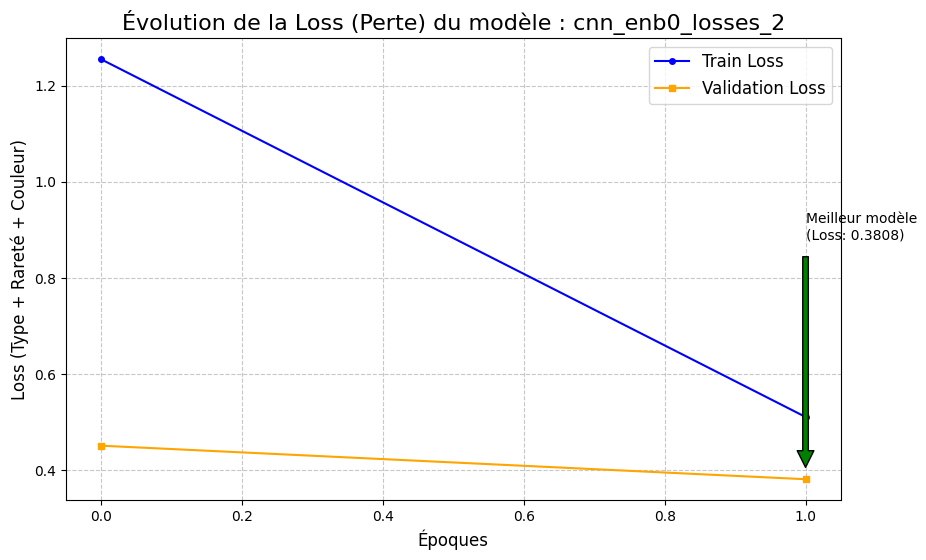

In [122]:
# Chargement des losses sauvegardées
try:
    with open(loss_save_path, "r") as f:
        history = json.load(f)
    
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    model_name = os.path.basename(loss_save_path)
    print(f"Losses du modèle {Path(model_name).stem} chargées.")
except FileNotFoundError:
    print(f"Erreur : Le fichier {Path(loss_save_path).stem} n'a pas été trouvé.")
    train_losses, val_losses = [], []
    model_name = "Inconnu"

# Configuration du style
plt.figure(figsize=(10, 6))
plt.title(f"Évolution de la Loss (Perte) du modèle : {Path(model_name).stem}", fontsize=16)

# Tracé des courbes
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='-', marker='s', markersize=4)

# Labels et Légende
plt.xlabel("Époques", fontsize=12)
plt.ylabel("Loss (Type + Rareté + Couleur)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Annotation du minimum
if len(val_losses) > 0:
    min_val_loss = min(val_losses)
    min_epoch = val_losses.index(min_val_loss)
    plt.annotate(f'Meilleur modèle\n(Loss: {min_val_loss:.4f})',
                 xy=(min_epoch, min_val_loss), 
                 xytext=(min_epoch, min_val_loss + 0.5),
                 arrowprops=dict(facecolor='green', shrink=0.05))

plt.show()

Ramasse miettes (à exécuter en cas de problème de mémoire sur le GPU)

In [ ]:
import gc

# 1. Delete the variable
del model
del train_dataset
del val_dataset
del test_dataset
del train_loader
del val_loader
del test_loader

# 2. Trigger Python's garbage collector
gc.collect()

# 3. Clear the PyTorch cache
torch.cuda.empty_cache()